In [19]:
from Utils.Config import DATA_DIR
from Utils.Config import CHARTS_DIR
from Utils import dataUtils
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import os

In [20]:
path = dataUtils.getDataPaths(2)
data = dataUtils.concat_dfs("prices", path)[:300]

<Axes: >

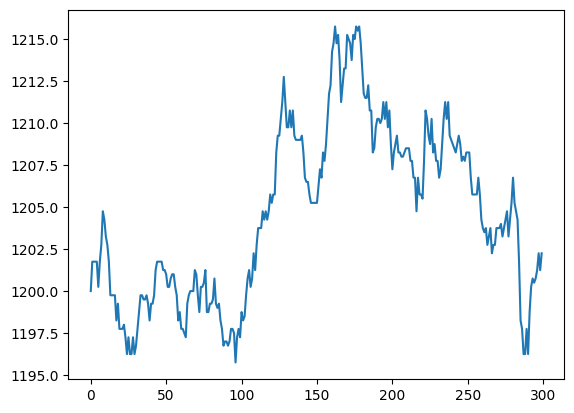

In [21]:
data["ORCHIDS"].plot()

Feature Analysis EDA

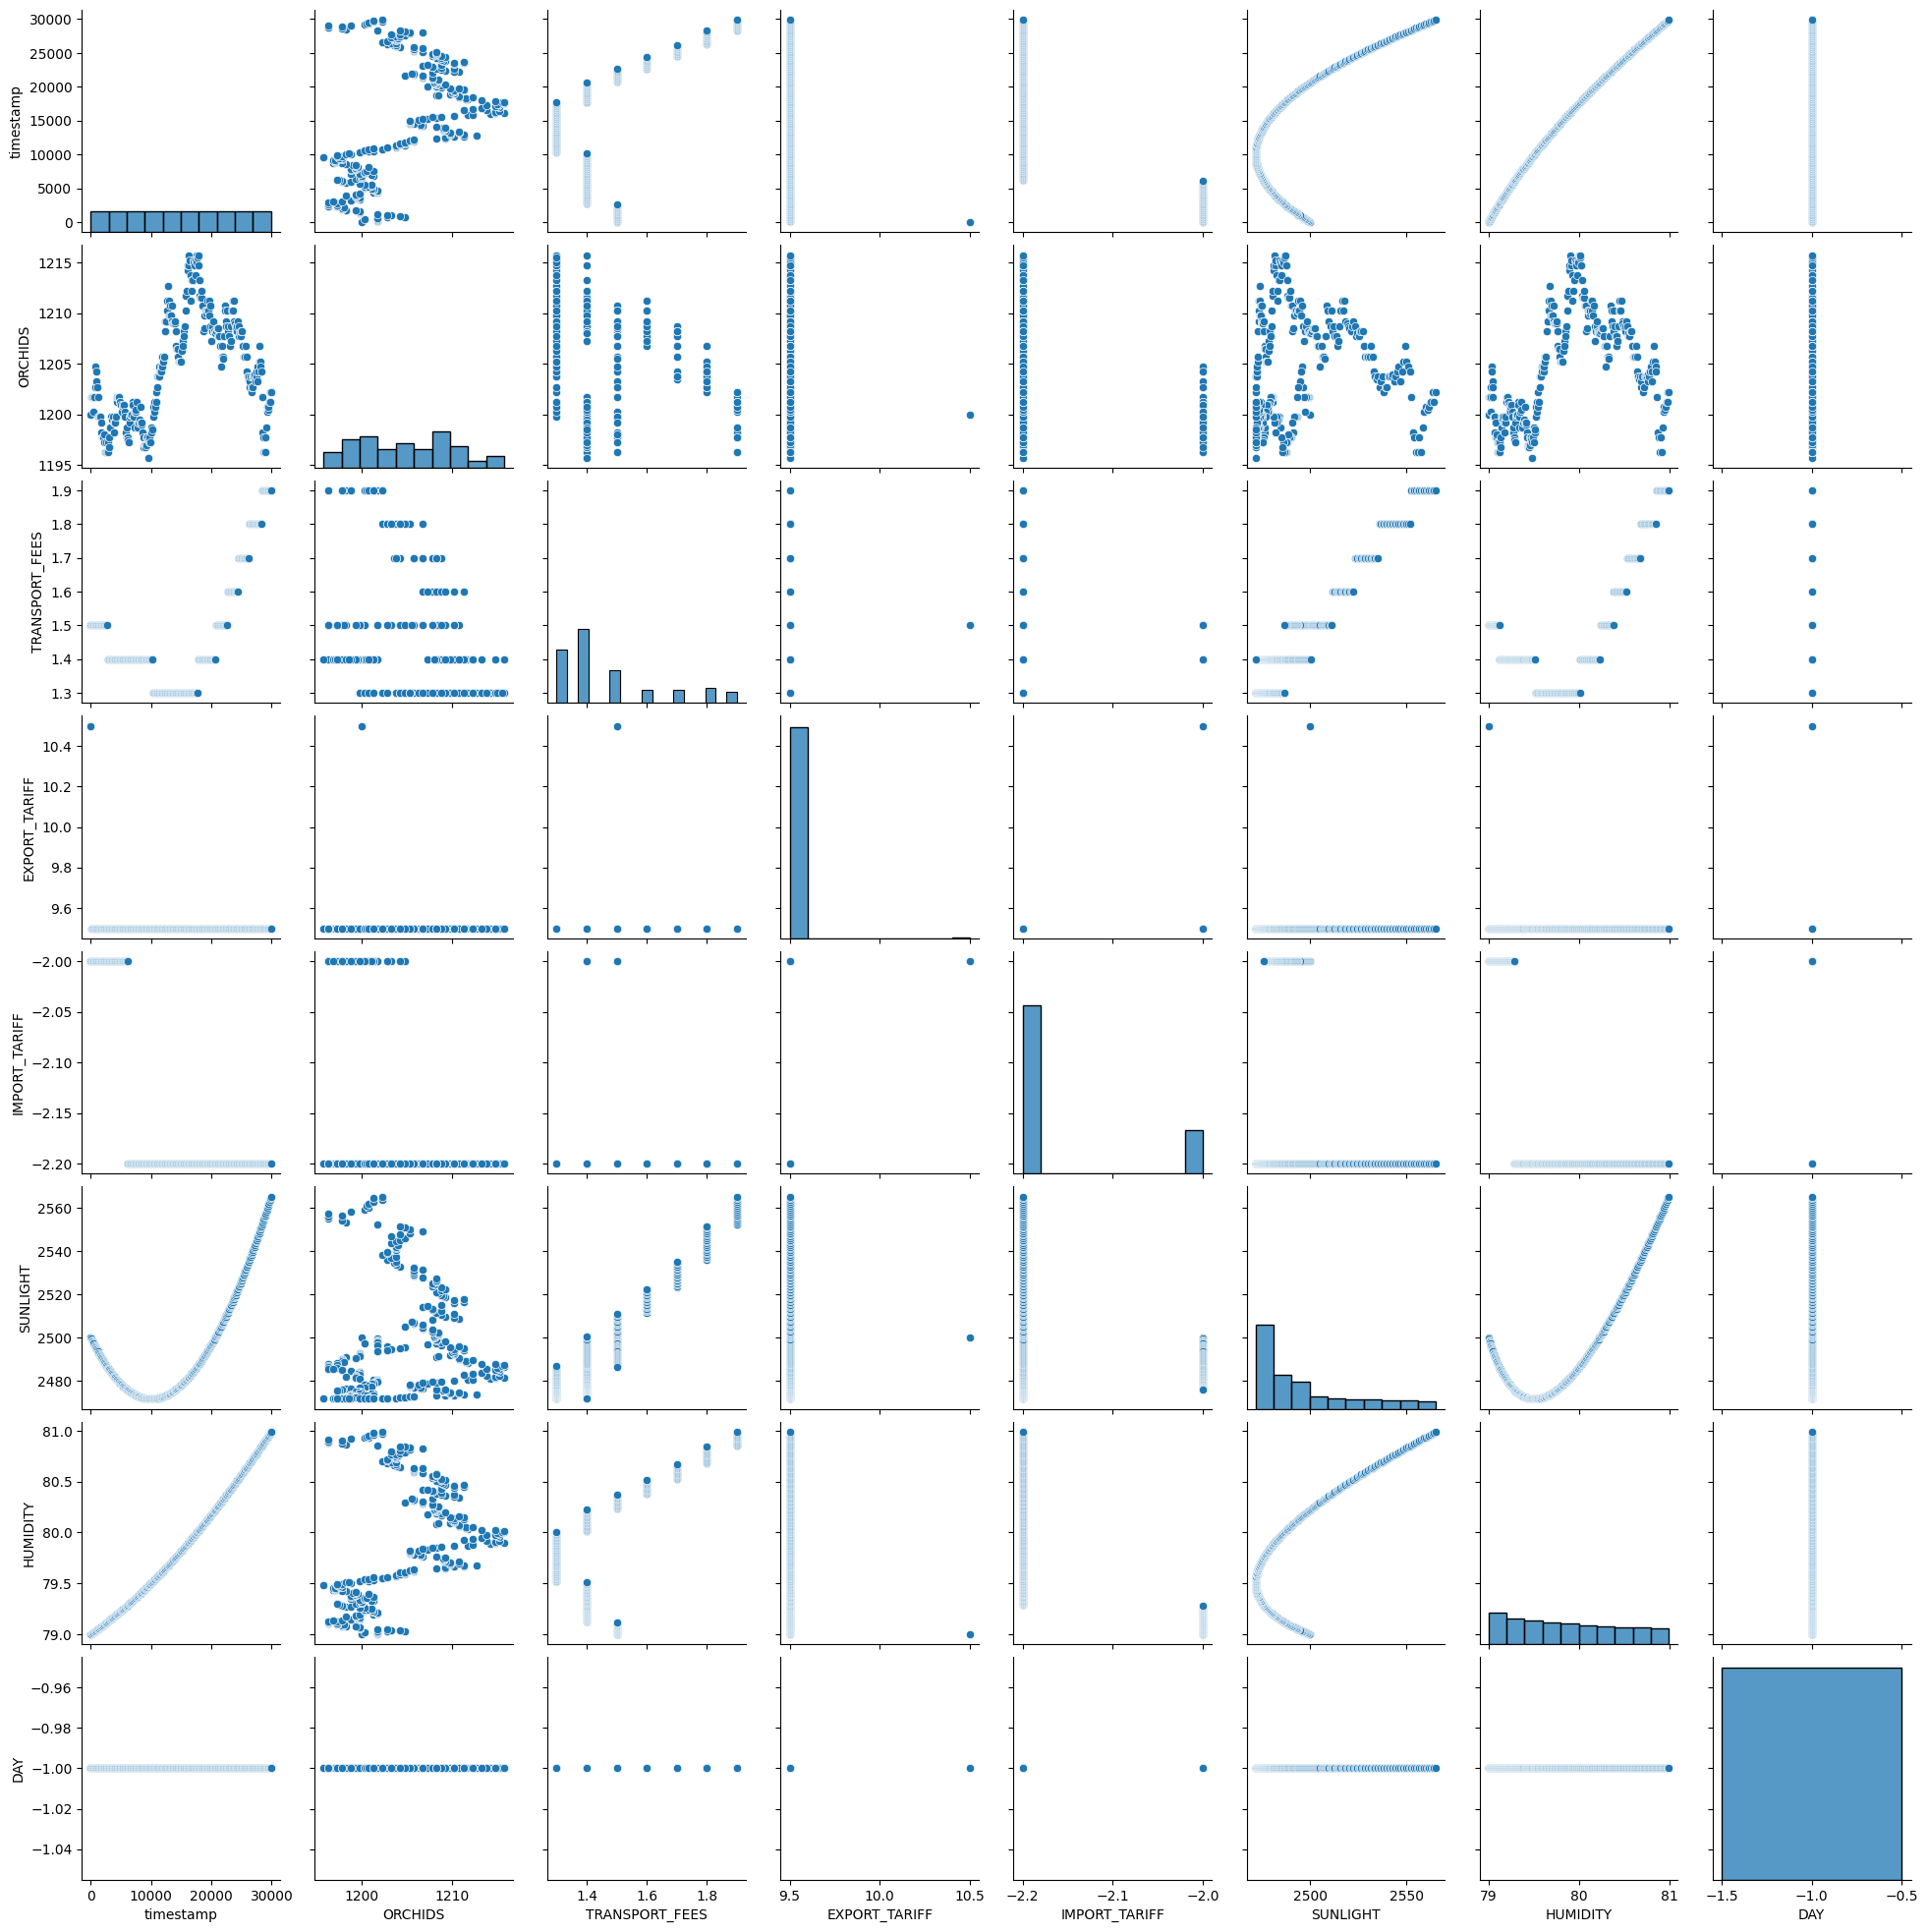

In [22]:
import seaborn as sns

features = ["ORCHIDS","TRANSPORT_FEES", "EXPORT_TARIFF", "IMPORT_TARIFF", "SUNLIGHT", "HUMIDITY"]
sns.pairplot(data)

Linear Regression Parameters to predict the price of orchids

In [23]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


data["ET"] = data["EXPORT_TARIFF"].rolling(100).mean()
data["TFees"] = data["TRANSPORT_FEES"].rolling(100).mean()
data["IT"] = data["IMPORT_TARIFF"].rolling(100).mean()
data["S"] = data["SUNLIGHT"].rolling(100).mean()
data["H"] = data["HUMIDITY"].rolling(100).mean()

data.dropna(inplace=True)

X = data[["TFees", "ET", "IT", "S", "H"]]
y = data["ORCHIDS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42,shuffle=False)
model = Lasso()
model.fit(X_train, y_train)

preds = model.predict(X_test)
print(mean_squared_error(y_test, preds))

7.3237225335651805


[-0.         -0.         -0.         -0.14691914  0.        ]


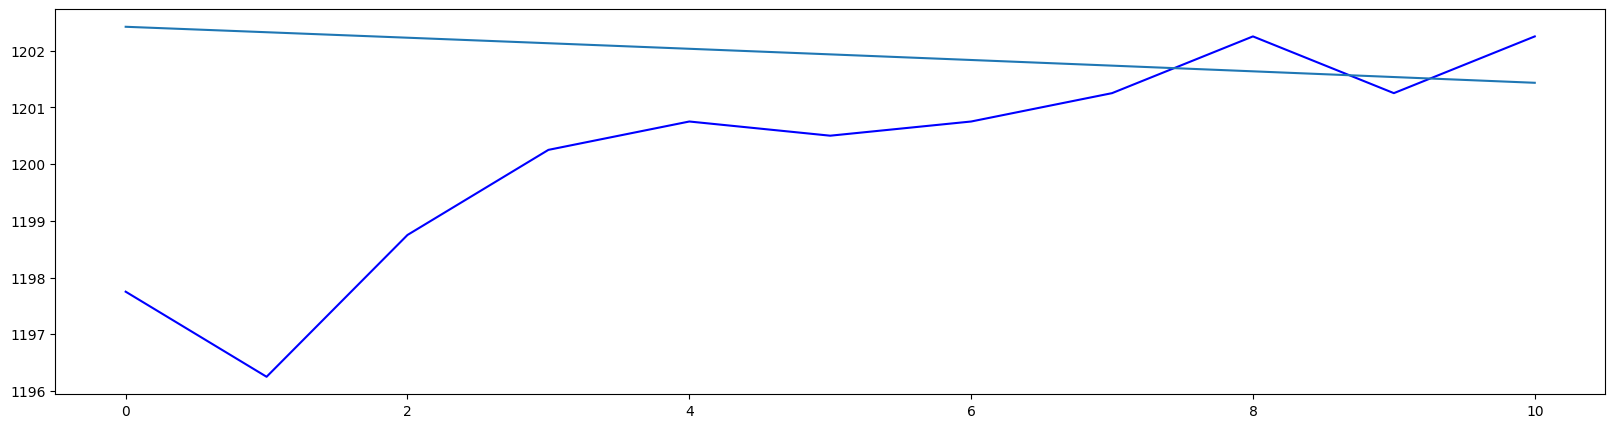

In [24]:
fig = plt.figure(figsize=(20,5))
plt.plot(y_test.values, color="blue")
plt.plot(preds)

print(model.coef_)

Feature Enginering and Model Improvement

In [25]:
#Filtering ORCHIDS:

sig = data.ORCHIDS.values
window = 3
savgol_preds = dataUtils.savitzky_golay(sig,window_size=3,order=3)
fig = plt.figure(figsize=(15,5))
plt.plot(sig)
plt.plot(savgol_preds)

data["H_fil"] = sc.signal.savgol_filter(data.HUMIDITY, window_length=3, polyorder=1, mode="nearest")
data["S_fil"] = sc.signal.savgol_filter(data.SUNLIGHT, window_length=3, polyorder=1, mode="nearest")
data["savgol_price"] = savgol_preds
data["savgol_gradient"] = np.gradient(data.savgol_price)

data["ORCHIDS_SMA25"] = data["ORCHIDS"].rolling(25).mean()
data.dropna(inplace=True)

mean_squared_error(sig,savgol_preds)


TypeError: window_size is too small for the polynomials order

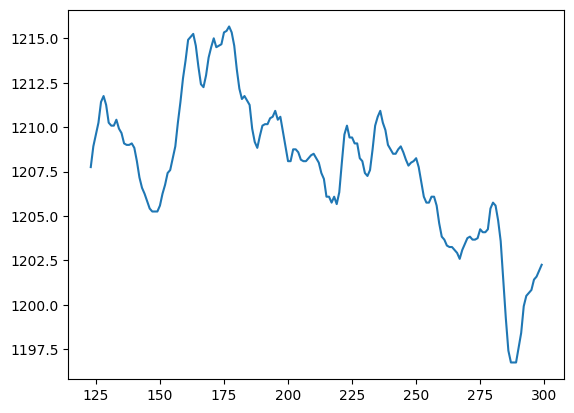

In [8]:
plt.plot(data.savgol_price)

[-0.         -0.         -0.         -0.14691914  0.        ]


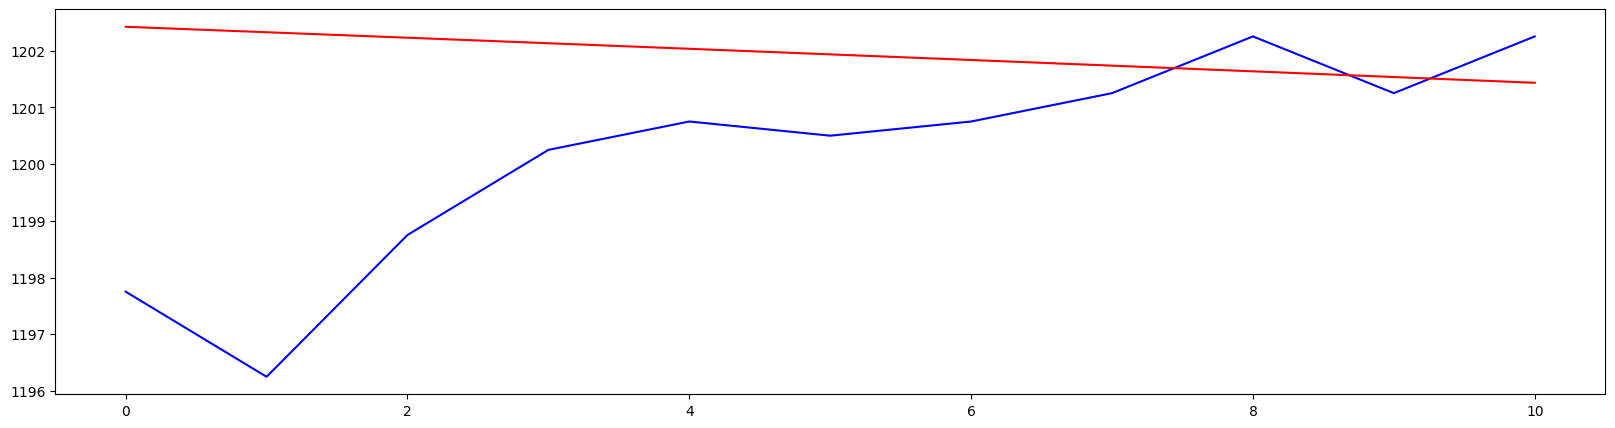

In [9]:
fig = plt.figure(figsize=(20,5))
plt.plot(y_test.values, color="blue")
plt.plot(preds, color = "red")

print(model.coef_)

In [10]:
savgol_preds = data["savgol_price"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


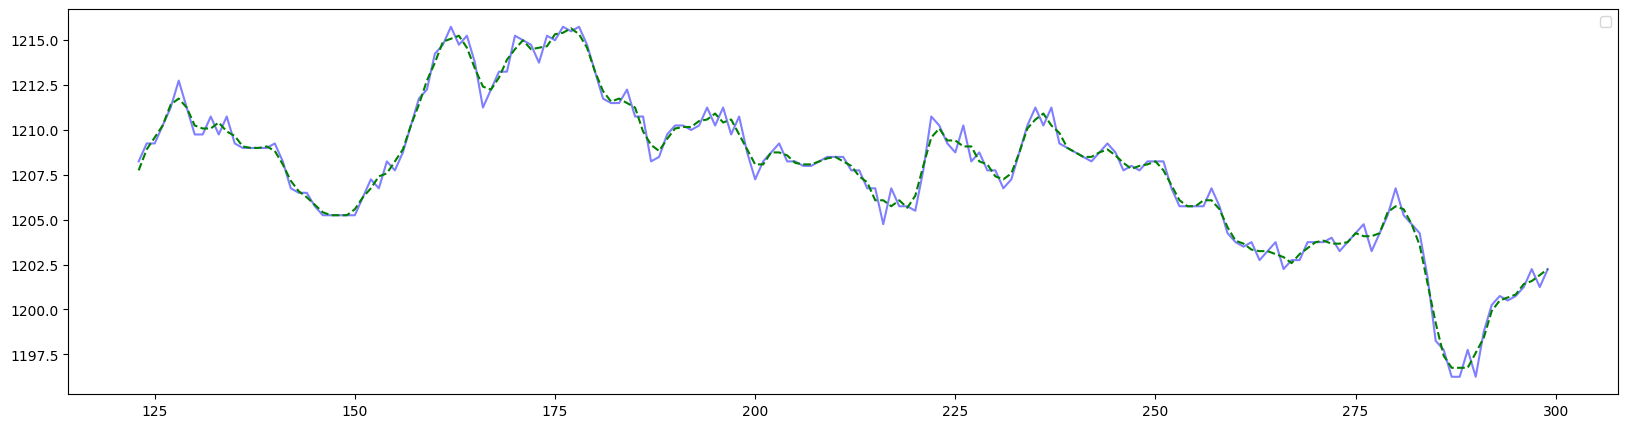

In [11]:
fig = plt.figure(figsize=(20,5))
plt.plot(data.ORCHIDS, color="blue", alpha=0.5)
plt.plot(data.savgol_price, color="green", linestyle="dashed")
plt.legend()

- Use the gradient of the curve to sell or buy if price is bellow or aboev predictions and slope close to 0

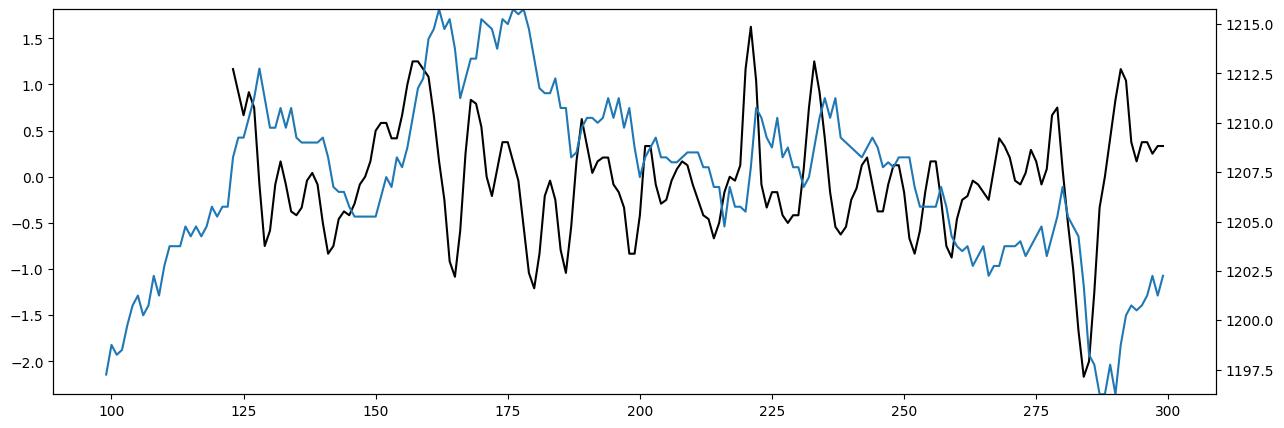

In [12]:
x = np.arange(0,len(savgol_preds))
dx = np.diff(x)
dy = np.diff(y)
d = np.gradient(savgol_preds)


fig, ax1 = plt.subplots(figsize=(15, 5))
ax2 = ax1.twinx()  
ax2.set_ylim(data.ORCHIDS.min(),data.ORCHIDS.max())
ax1.plot(data.savgol_gradient, color="black")
ax2.plot(y)

#plt.plot(savgol_preds)
savgol_signals = y

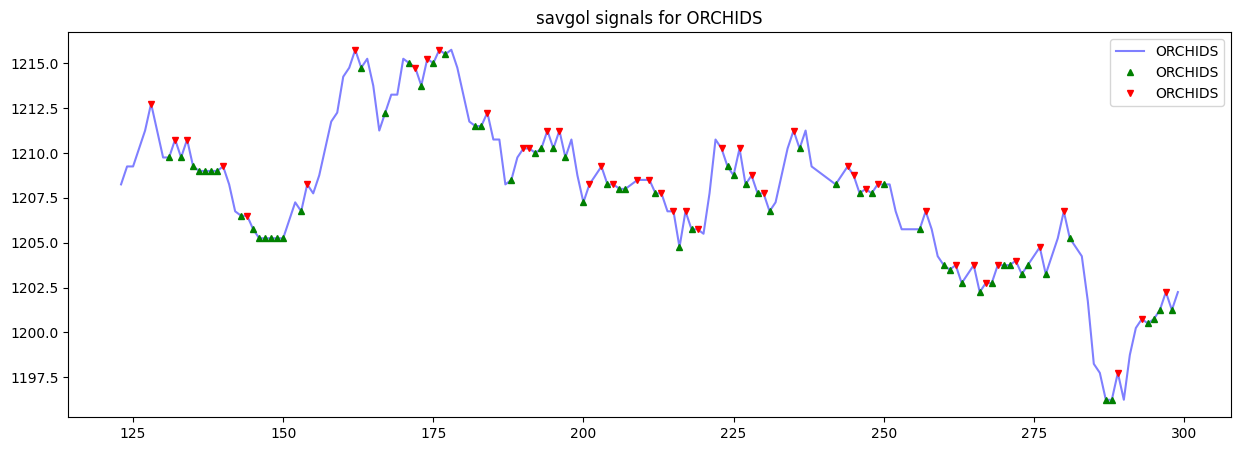

In [16]:
umbral_slope = 0.50
umbral_orchids = 100

# Aplicar filtro y crear la columna signal
data['signal_sell'] = np.where(
    (np.isclose(data['savgol_gradient'], 0, atol=umbral_slope)) & 
    (data['ORCHIDS'] > data["savgol_price"]),
    -1,
    0
)
data['signal_buy'] = np.where(
    (np.isclose(data['savgol_gradient'], 0, atol=umbral_slope)) & (data['ORCHIDS'] < data["savgol_price"]),
    1,
    0
)
fig = plt.figure(figsize=(15,5))
data["ORCHIDS"].plot(color="blue", alpha=0.5)
data["ORCHIDS"][data.signal_buy==1].plot(marker="^", markersize=5, color='g',linestyle='')
data["ORCHIDS"][data.signal_sell==-1].plot(marker="v", markersize=5, color='r',linestyle='')
title = "savgol signals for ORCHIDS"
plt.legend()
plt.title(title)
plt.savefig(f"{CHARTS_DIR}/R2_{title}.jpg")

Use a classification model to find parameters of when to sell or buy with savgol signal

In [14]:
y = np.array([5000,5001,5003,5004,5000])
yhat = dataUtils.savitzky_golay(y,3,1)
np.gradient(yhat)

array([1.33333333, 1.33333333, 0.5       , 0.        , 0.33333333])

In [15]:
np.zeros((3,4,3))

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])